In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
from transformers import BertModel, AutoTokenizer, GPT2Model
import torch
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
from datasets import load_dataset

/home/konrad-kielczynski/miniconda3/envs/golem-ner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BERT_MODEL_ID = "google-bert/bert-base-multilingual-uncased"
GPT2_MODEL_ID = "sdadas/polish-gpt2-medium"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

PATH_POSTFIX = "gpt2"
PATH_POSTFIX_OPTIONS = ["bert", "gpt2"]

In [4]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'phrases', 'wsd'],
        num_rows: 7848
    })
})

In [6]:
dataset = dataset['train']

In [7]:
words = [
    i['orth'] for i in dataset['tokens']
]


In [8]:
del dataset

In [9]:
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_ID)
bert_model = BertModel.from_pretrained(BERT_MODEL_ID).to(DEVICE)

In [9]:
gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_MODEL_ID, add_prefix_space=True)

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2 = GPT2Model.from_pretrained(GPT2_MODEL_ID, pad_token_id=gpt2_tokenizer.eos_token_id).to(DEVICE)

In [10]:
def get_word_embeddings(word_lists, tokenizer, model, device, batch_size=2):
    word_embeddings = []

    for i in tqdm(range(0, len(word_lists), batch_size)):
        batch = word_lists[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, is_split_into_words=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs, return_dict=True, output_hidden_states=True)

        hidden_states = outputs.hidden_states
        hidden_states = tuple([layer.to('cpu') for layer in hidden_states])

        del outputs

        for b in range(len(batch)):
            word_embs_per_layer = []

            for layer in hidden_states:

                token_embeddings = layer[b]  # Get the embeddings for the b-th text in the batch
                word_ids = inputs.word_ids(batch_index=b)

                word_embs = []
                current_word_emb = []
                current_word_id = None

                for j, word_id in enumerate(word_ids):

                    if word_id is None:
                        continue

                    if (word_id == current_word_id) or (current_word_id is None):
                        current_word_emb.append(token_embeddings[j])
                    else:
                        word_embs.append(torch.mean(torch.stack(current_word_emb), dim=0))
                        current_word_emb = [token_embeddings[j]]

                    current_word_id = word_id

                if current_word_emb:
                    word_embs.append(torch.mean(torch.stack(current_word_emb), dim=0))

                word_embs_per_layer.append(torch.stack(word_embs))

            word_embeddings.append(word_embs_per_layer)

    return word_embeddings

In [14]:
word_embeddings = get_word_embeddings(words[:128], gpt2_tokenizer, gpt2, DEVICE, batch_size=8)

100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


In [15]:
def calculate_average_cosine_similarity(word_embeddings, n=100):
    
    layer_similarities = {}

    for layer in range(len(word_embeddings[0])):

        all_embeddings = torch.concat([text_embs[layer] for text_embs in word_embeddings])
        num_embeddings = all_embeddings.size(0)

        # Sample n pairs of indices
        indices = torch.randint(0, num_embeddings, (n, 2))

        # Get the embeddings for the sampled pairs
        emb1 = all_embeddings[indices[:, 0]]
        emb2 = all_embeddings[indices[:, 1]]

        # Calculate cosine similarity for the sampled pairs
        similarities = cosine_similarity(emb1, emb2, dim=1)

        average_similarity = similarities.mean().item()
        layer_similarities[layer] = average_similarity

    return layer_similarities

In [16]:
import pickle
filename = f'layer_similarities_{PATH_POSTFIX}.json'

In [17]:
layer_similarities = calculate_average_cosine_similarity(word_embeddings, n=100)


with open(filename, 'wb') as f:
    pickle.dump(layer_similarities, f)


In [19]:
layer_similarities = {}

for postfix in PATH_POSTFIX_OPTIONS:
    filename = f'layer_similarities_{postfix}.json'
    with open(filename, 'rb') as f:
        layer_similarities[postfix] = pickle.load(f)

layer_similarities

{'bert': {0: 0.07623529434204102,
  1: 0.17976665496826172,
  2: 0.23452791571617126,
  3: 0.2901037037372589,
  4: 0.3450257182121277,
  5: 0.38440608978271484,
  6: 0.43940967321395874,
  7: 0.48032838106155396,
  8: 0.5137536525726318,
  9: 0.5215864777565002,
  10: 0.45007574558258057,
  11: 0.4862191379070282,
  12: 0.31808072328567505},
 'gpt2': {0: 0.0653679296374321,
  1: 0.602645218372345,
  2: 0.5816879868507385,
  3: 0.5946292281150818,
  4: 0.5722466111183167,
  5: 0.5312464237213135,
  6: 0.5332477688789368,
  7: 0.5137730240821838,
  8: 0.4962649643421173,
  9: 0.492135226726532,
  10: 0.4614359140396118,
  11: 0.474597692489624,
  12: 0.47585639357566833,
  13: 0.46845731139183044,
  14: 0.4648028314113617,
  15: 0.4807971119880676,
  16: 0.46028023958206177,
  17: 0.437355637550354,
  18: 0.46549397706985474,
  19: 0.46966752409935,
  20: 0.4940674304962158,
  21: 0.5438836812973022,
  22: 0.5974611639976501,
  23: 0.6405121088027954,
  24: 0.20247478783130646}}

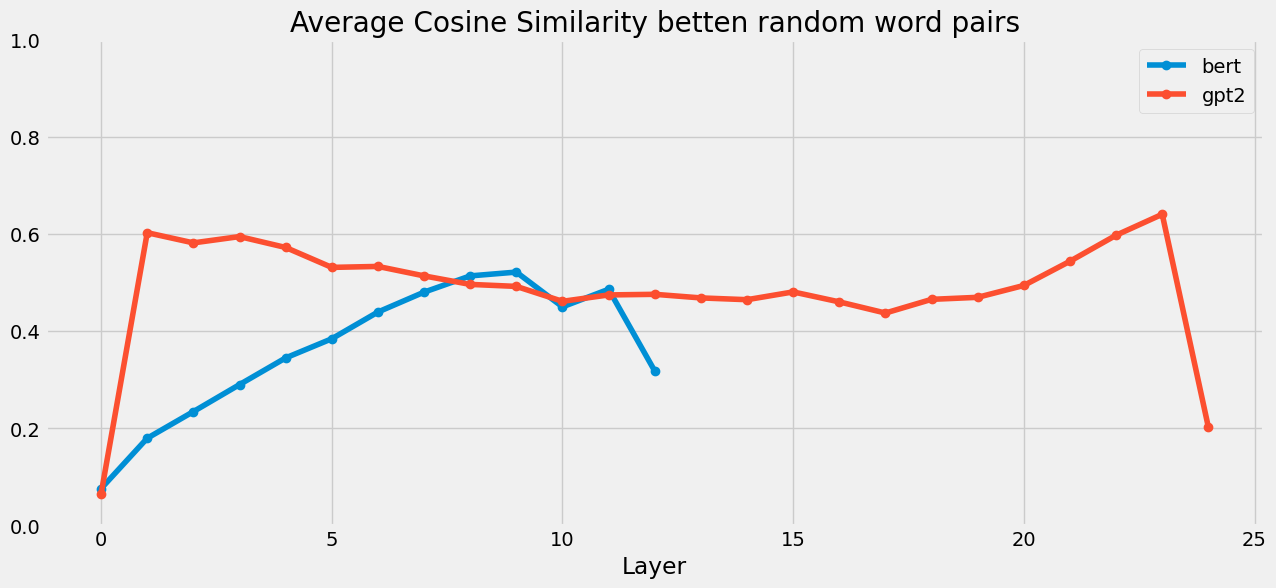

In [39]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 6))



for model in PATH_POSTFIX_OPTIONS:
    layers = list(layer_similarities[model].keys())
    similarities = list(layer_similarities[model].values())

    plt.plot(layers, similarities, marker='o', linestyle='-', label=model)


# Add title and labels
plt.title('Average Cosine Similarity betten random word pairs')
plt.xlabel('Layer')
plt.ylabel('')

# Set y-axis scale from 0 to 1
plt.ylim(0, 1)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [22]:
from collections import defaultdict

In [23]:
def calculate_average_cosine_similarity_same_words(word_embeddings, words, n=100):

    layer_similarities = {}

    for layer in range(len(word_embeddings[0])):
        word_to_embeddings = defaultdict(list)

        for text_embs, text_words in zip(word_embeddings, words):

            for word, emb in zip(text_words, text_embs[layer]):
                word_to_embeddings[word].append(emb)

        # print(f'{word_to_embeddings.keys() = }')

        word_similarities = {}

        for word, embeddings in word_to_embeddings.items():

            # word_similarities[word] = None

            if len(embeddings) > 2:

                embeddings = torch.stack(embeddings)
                # print(f'{embeddings.shape = }')
                
                sim = cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
                # print(f'{sim.shape = }')
                triu_indices = torch.triu_indices(sim.size(0), sim.size(1), offset=1)
                sim_values = sim[triu_indices[0], triu_indices[1]]
                word_similarities[word] = sim_values.mean().item()

        layer_similarities[layer] = word_similarities

    return layer_similarities

In [31]:
word_sims = calculate_average_cosine_similarity_same_words(word_embeddings, words[:128], n=100)

In [32]:
word_sims

{0: {'Zatem': 0.6542596220970154,
  'to': 0.94361412525177,
  'pani': 0.9768322706222534,
  'siostra': 0.9751896262168884,
  'o': 0.9583335518836975,
  'niego': 0.9687713384628296,
  '?': 0.9675677418708801,
  ',': 0.9660486578941345,
  'nigdy': 0.9628031253814697,
  'nie': 0.9534347057342529,
  'słyszała': 0.9851221442222595,
  'm': 0.9728503823280334,
  'żeby': 0.9685019254684448,
  'go': 0.9709476232528687,
  '.': 0.9625966548919678,
  'śmy': 0.9643204808235168,
  'się': 0.9649266600608826,
  'bez': 0.9708248376846313,
  'W': 0.8567625880241394,
  'istocie': 0.9736773371696472,
  'tak': 0.9621739387512207,
  'w': 0.9567312598228455,
  'tym': 0.9562668204307556,
  'miejscu': 0.9786815047264099,
  'teraz': 0.9784464836120605,
  'i': 0.9555923342704773,
  'mi': 0.9789385795593262,
  'kilka': 0.9597029685974121,
  'minut': 0.9705061912536621,
  'na': 0.9547703862190247,
  'z': 0.9567418694496155,
  'Holmes': 0.9731743931770325,
  'do': 0.9637098908424377,
  'podłogi': 0.9829457402229309

In [33]:
mean_layer_sims = {layer: np.mean(list(word_sims[layer].values())) for layer in word_sims}

In [34]:
mean_layer_sims

{0: 0.9592290351393707,
 1: 0.8780801653073009,
 2: 0.868978906983216,
 3: 0.8573863811871635,
 4: 0.8384807296680056,
 5: 0.8166451503653819,
 6: 0.7990964588705813,
 7: 0.7872098793693685,
 8: 0.7829347615064123,
 9: 0.7695591937835753,
 10: 0.760588761235259,
 11: 0.7533977885610647,
 12: 0.7507296192014834,
 13: 0.751804168904301,
 14: 0.7489314053821793,
 15: 0.7421084868348462,
 16: 0.722771692935884,
 17: 0.7105500839390623,
 18: 0.6996445413746128,
 19: 0.6937234874021275,
 20: 0.6985750080015685,
 21: 0.7139739754254494,
 22: 0.7452224512392863,
 23: 0.7534540155017132,
 24: 0.5060730800480906}

In [35]:
path = f'word_sims_{PATH_POSTFIX}.json'

with open(path, 'wb') as f:
    pickle.dump(word_sims, f)

In [36]:
mean_layer_sims = {}

for postfix in PATH_POSTFIX_OPTIONS:
    filename = f'word_sims_{postfix}.json'
    with open(
        filename, 'rb'
    ) as f:
        word_sims = pickle.load(f)
        mean_layer_sims[postfix] = {layer: np.mean(list(word_sims[layer].values())) for layer in word_sims}
    

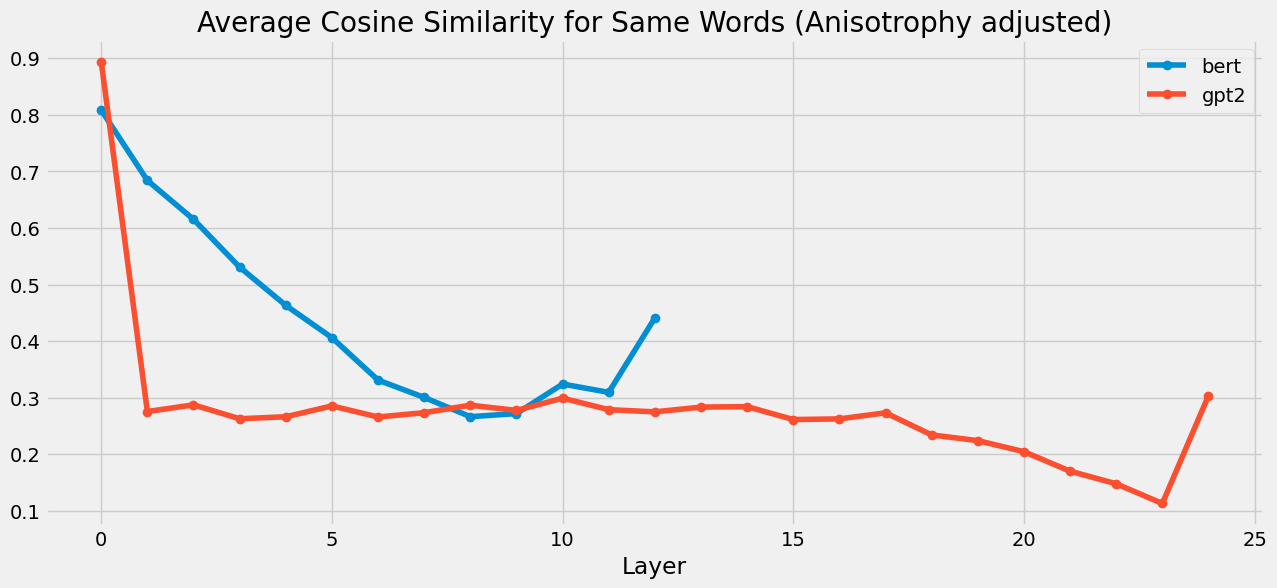

In [52]:
plt.figure(figsize=(14, 6))


for model in PATH_POSTFIX_OPTIONS:
    layers = list(mean_layer_sims[model].keys())
    similarities = list(mean_layer_sims[model].values())

    similarities = np.array(similarities) - np.array(list(layer_similarities[model].values()))

    plt.plot(layers, similarities, marker='o', linestyle='-', label=model)



# Add title and labels
plt.title('Average Cosine Similarity for Same Words (Anisotrophy adjusted)')
plt.xlabel('Layer')
plt.ylabel('')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [40]:
def get_sentence_embeddings_from_word_embeddings(word_embeddings, words):

    sentence_indices = []
    current_sentence = []

    for word_list in words:

        for i, word in enumerate(word_list):
            current_sentence.append(word)

            if i != len(word_list) - 1:

                if (word in ['!', '?', '.']) and (word_list[i + 1].istitle()):
                    sentence_indices.append(current_sentence)
                    current_sentence = []

        if current_sentence:
            sentence_indices.append(current_sentence)
            current_sentence = []

    return sentence_indices

In [41]:
sentences = get_sentence_embeddings_from_word_embeddings(word_embeddings, words[:128])

In [43]:
word_embeddings_sentences = get_word_embeddings(sentences, gpt2_tokenizer, gpt2, DEVICE, batch_size=8)

100%|██████████| 172/172 [00:08<00:00, 20.06it/s]


In [44]:
def calculate_average_cosine_similarity_sentence(words_sentence_embeddings, n=100):
    
    layer_similarities = {}

    for layer in range(len(words_sentence_embeddings[0])):

        layer_similarities[layer] = []

        for sentence_words in words_sentence_embeddings:

            sentence_emb = torch.mean(sentence_words[layer], dim=0)
            sent_cosine_sim = cosine_similarity(sentence_emb.unsqueeze(0), sentence_words[layer], dim=1).mean().item()

            layer_similarities[layer].append(sent_cosine_sim)

        layer_similarities[layer] = np.mean(layer_similarities[layer])

    return layer_similarities

In [45]:
mean_sent_sims = calculate_average_cosine_similarity_sentence(word_embeddings_sentences, n=100)

In [46]:
mean_sent_sims

{0: 0.4490578434601122,
 1: 0.8253255466938714,
 2: 0.818468756561029,
 3: 0.7766565569288182,
 4: 0.7152999195517326,
 5: 0.6673160133009054,
 6: 0.6423706612807669,
 7: 0.6280837097903035,
 8: 0.6194655669760774,
 9: 0.6211224029562912,
 10: 0.6267228646111558,
 11: 0.6369212650783556,
 12: 0.6459204144015604,
 13: 0.6558367376033836,
 14: 0.6668768970203469,
 15: 0.6748764428904731,
 16: 0.6820069849925555,
 17: 0.693725852159995,
 18: 0.7092430030291699,
 19: 0.723816870209427,
 20: 0.746800782772612,
 21: 0.7719582481304341,
 22: 0.8042616310255173,
 23: 0.8418587351071244,
 24: 0.6570849539413397}

In [47]:
path= f'mean_sent_sims_{PATH_POSTFIX}.json'

In [48]:
with open(path, 'wb') as f:
    pickle.dump(mean_sent_sims, f)

In [50]:
mean_sent_sims = {}

for postfix in PATH_POSTFIX_OPTIONS:
    filename = f'mean_sent_sims_{postfix}.json'
    with open(
        filename, 'rb'
    ) as f:
        mean_sent_sims[postfix] = pickle.load(f)

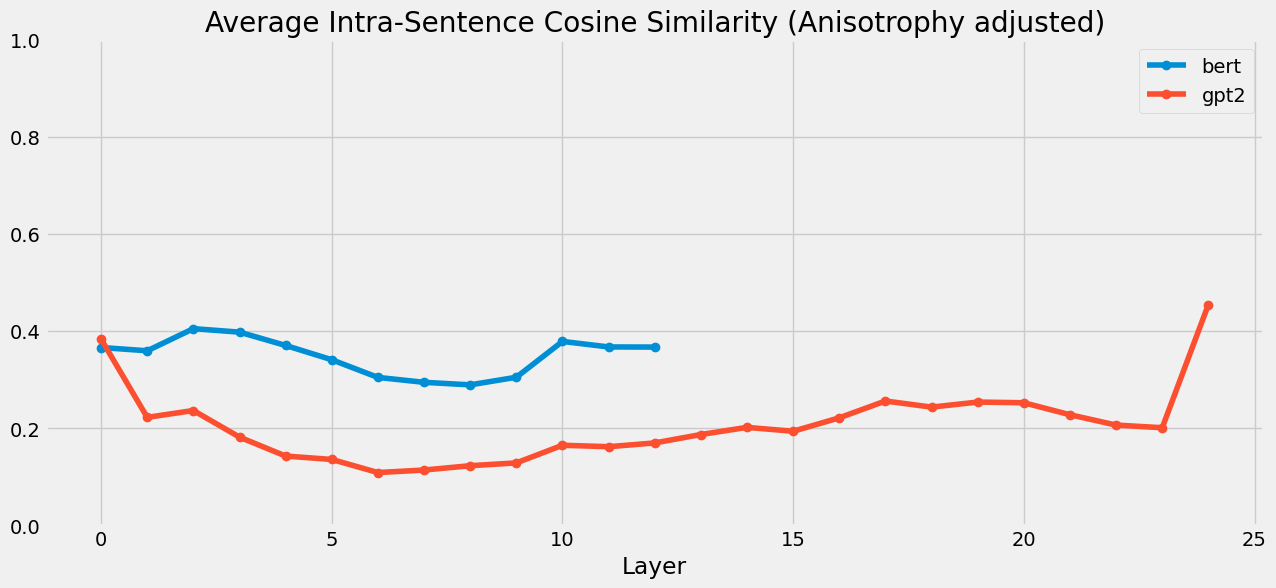

In [53]:
plt.figure(figsize=(14, 6))


for model in PATH_POSTFIX_OPTIONS:
    layers = list(mean_sent_sims[model].keys())
    similarities = list(mean_sent_sims[model].values())

    similarities = np.array(similarities) - np.array(list(layer_similarities[model].values()))

    plt.plot(layers, similarities, marker='o', linestyle='-', label=model)




# Add title and labels
plt.title('Average Intra-Sentence Cosine Similarity (Anisotrophy adjusted)')
plt.xlabel('Layer')
plt.ylabel('')


plt.ylim(0, 1)
# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()